Ce notebook est dédié à la prédiction de la densité en nucléosome sur l'ensemble du chromosome de levure ainsi que sur les génomes de bactérie intégrés dans la levure.

In [1]:
import numpy as np
import keras
import h5py
import pandas as pd
import os
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from MyModuleLibrary.array_modifier import rolling_window
from MyModuleLibrary.mykeras.losses import mae_cor, correlate

In [3]:
WINDOW = 2001
HALF_WX = WINDOW // 2

In [4]:
def one_hot_encoder(nucleotid):
    res = (np.arange(4) == nucleotid[..., None]-1).astype(int)
    res = res.reshape(res.shape[0], 4)
    return res

In [5]:
import matplotlib 
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16)

# Prediction sur l'ensemble du génome de la levure

In [50]:
! cp ../Projet_nucleosomes/Results_nucleosome/weights_myco_rep2.hdf5 ./models/weights_nucleosome_myco_rep2.hdf5
! cp ../Projet_nucleosomes/Results_nucleosome/weights_myco_rep3.hdf5 ./models/weights_nucleosome_myco_rep3.hdf5

In [58]:
model = keras.models.load_model('./models/weights_nucleosome_myco_rep3.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
#model = keras.models.load_model('../Projet_nucleosomes/Results_nucleosome/weights_CNN_nucleosome_in_vivo_chr4_cnn1.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})

In [88]:
def prepare_input(pathname):
    seq_chr = np.array(h5py.File(pathname)['data'])[:, 0]
    length = len(seq_chr)
    seq_chr_onehot = one_hot_encoder(seq_chr)
    X = rolling_window(seq_chr_onehot, window=(WINDOW, 4))[:, 0, :, None, :]
    return X, length

In [53]:
def predict_and_save(pathname, outname):
    X, length = prepare_input(pathname)
    
    prediction = np.zeros((length,))
    y = model.predict(X)
    prediction[HALF_WX : -HALF_WX] = y[:, 0]
    np.save(outname, prediction)

In [59]:
for i in range(1, 17):
    predict_and_save('../Projet_nucleosomes/Programme/seq_chr_sacCer3/W303/chr' + str(i) + '.hdf5',
                     './results/yeast/nucleosome_myco_rep3_chr' + str(i) + '.npy')

In [60]:
predict_and_save('./data/bacterie/Mmm_Linear_740kb.hdf5',
                 './results/bacterial/nucleosome_myco_3.npy')

In [202]:
for i in range(16, 17):
    predict_and_save('../Projet_nucleosomes/Programme/seq_chr_sacCer3/W303/chr' + str(i) + '.hdf5',
                     './results/yeast/nucleosome_pneu_rep1_chr' + str(i) + '.npy')

In [61]:
predict_and_save('./data/bacterie/Pneu300.hdf5',
                 './results/bacterial/nucleosome_pneu_3.npy')

# Représentation sur l'ensemble du génome

In [12]:
yeast_myco_files = ['./results/yeast/nucleosome_myco_rep1_chr' + str(i) + '.npy' for i in range(1, 17)]
myco_file = ['./results/bacterial/nucleosome_myco.npy']
yeast_pneu_files = ['./results/yeast/nucleosome_pneu_rep1_chr' + str(i) + '.npy' for i in range(1, 17)]
pneu_file = ['./results/bacterial/nucleosome_pneu.npy']

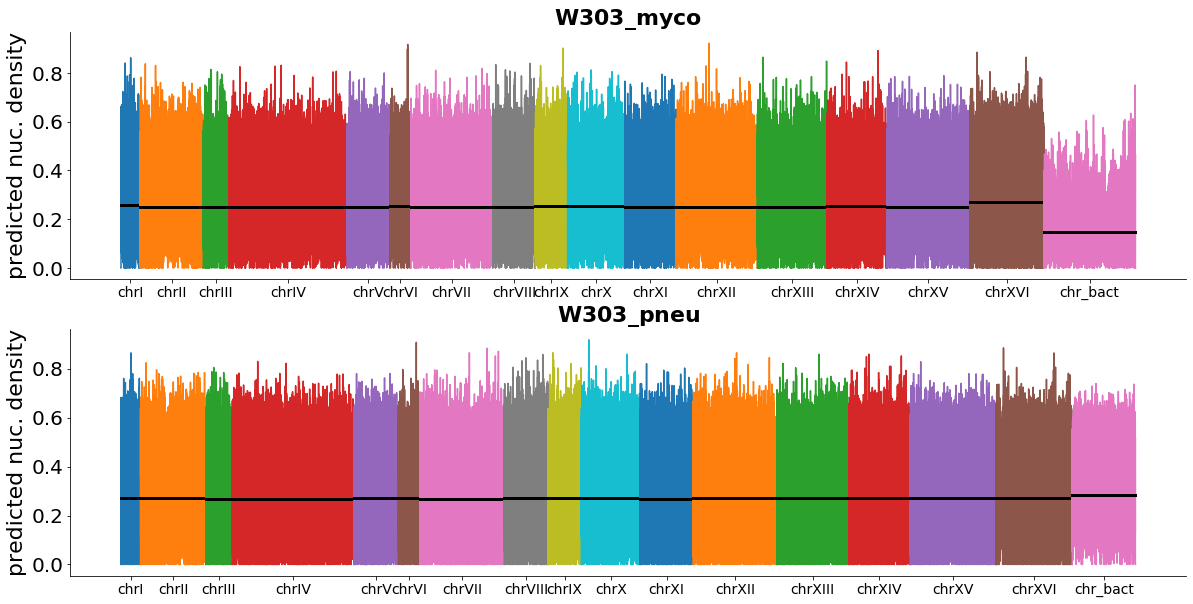

In [23]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(2, 1, 1)
start = 0
stop = 0
xticks = []

for file in yeast_myco_files + myco_file:
    prediction = np.log2(np.load(file) + 1)
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction)
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start +=len(prediction)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_title(r'$\bf{W303\_myco}$', fontsize=22)
ax.set_ylabel('predicted nuc. density', fontsize=22)

ax = fig.add_subplot(2, 1, 2)
start = 0
stop = 0
xticks = []

for file in yeast_pneu_files + pneu_file:
    prediction = np.log2(np.load(file) + 1)
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction)
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start +=len(prediction)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_title(r'$\bf{W303\_pneu}$', fontsize=22)
ax.set_ylabel('predicted nuc. density', fontsize=22)

fig.savefig('./results/nucleosome_density.png')

In [75]:
myco_coverage_rep1 = read_bed('./data/for_Julien/myco/coverage_RPKM_myco265.bed')
pneu_coverage_rep1 = read_bed('./data/for_Julien/pneumo/coverage_RPKM_pneumo205.bed')

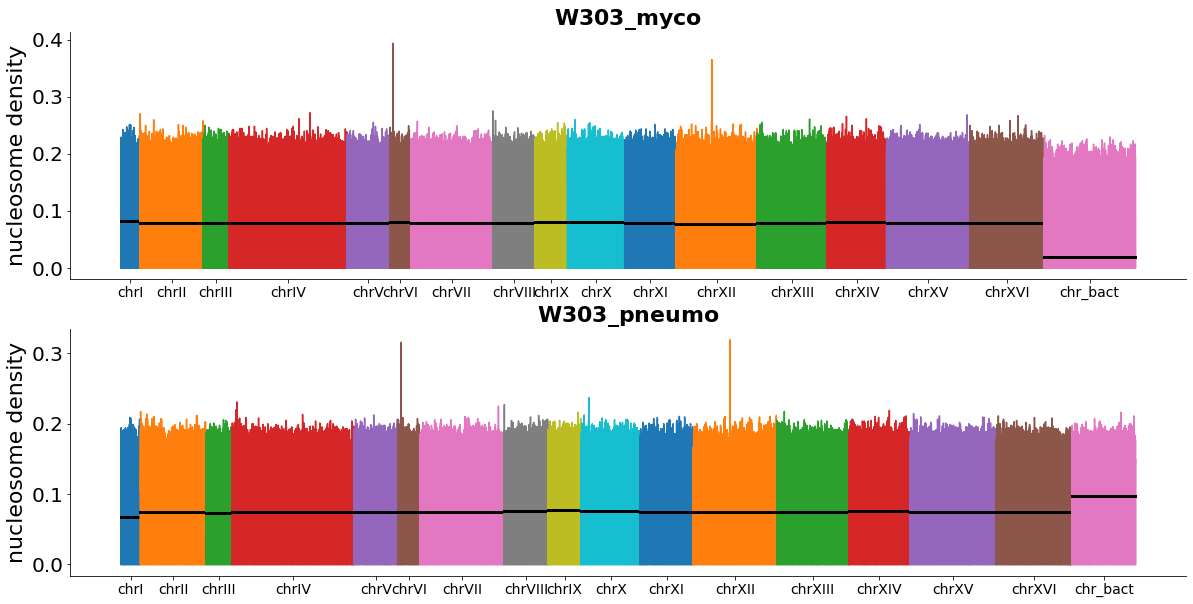

In [24]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(2, 1, 2)
start = 0
stop = 0
xticks = []

for chrom in ['chr01', 'chr02', 'chr03', 'chr04',
              'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
              'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16',
              'Pneu300']:

    prediction = pneu_coverage_rep1[chrom]
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction)
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start += len(prediction)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_title(r'$\bf{W303\_pneumo}$', fontsize=22)
ax.set_ylabel('nucleosome density', fontsize=22)

ax = fig.add_subplot(2, 1, 1)
start = 0
stop = 0
xticks = []

for chrom in ['chr01', 'chr02', 'chr03', 'chr04',
              'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
              'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16',
              'Mmm_Linear_740kb.fa']:
    
    prediction = myco_coverage_rep1[chrom]
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction)
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start += len(prediction)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_title(r'$\bf{W303\_myco}$', fontsize=22)
ax.set_ylabel('nucleosome density', fontsize=22)

fig.savefig('./results/nucleosome_density_experimental.png')

## Reprise des figures

In [77]:
all_coverage = np.concatenate([np.load(file) for file in yeast_myco_files + myco_file])
threshold_myco = np.sum(all_coverage) / 1e6

all_coverage = np.concatenate([np.load(file) for file in yeast_pneu_files + pneu_file])
threshold_pneu = np.sum(all_coverage) / 1e6

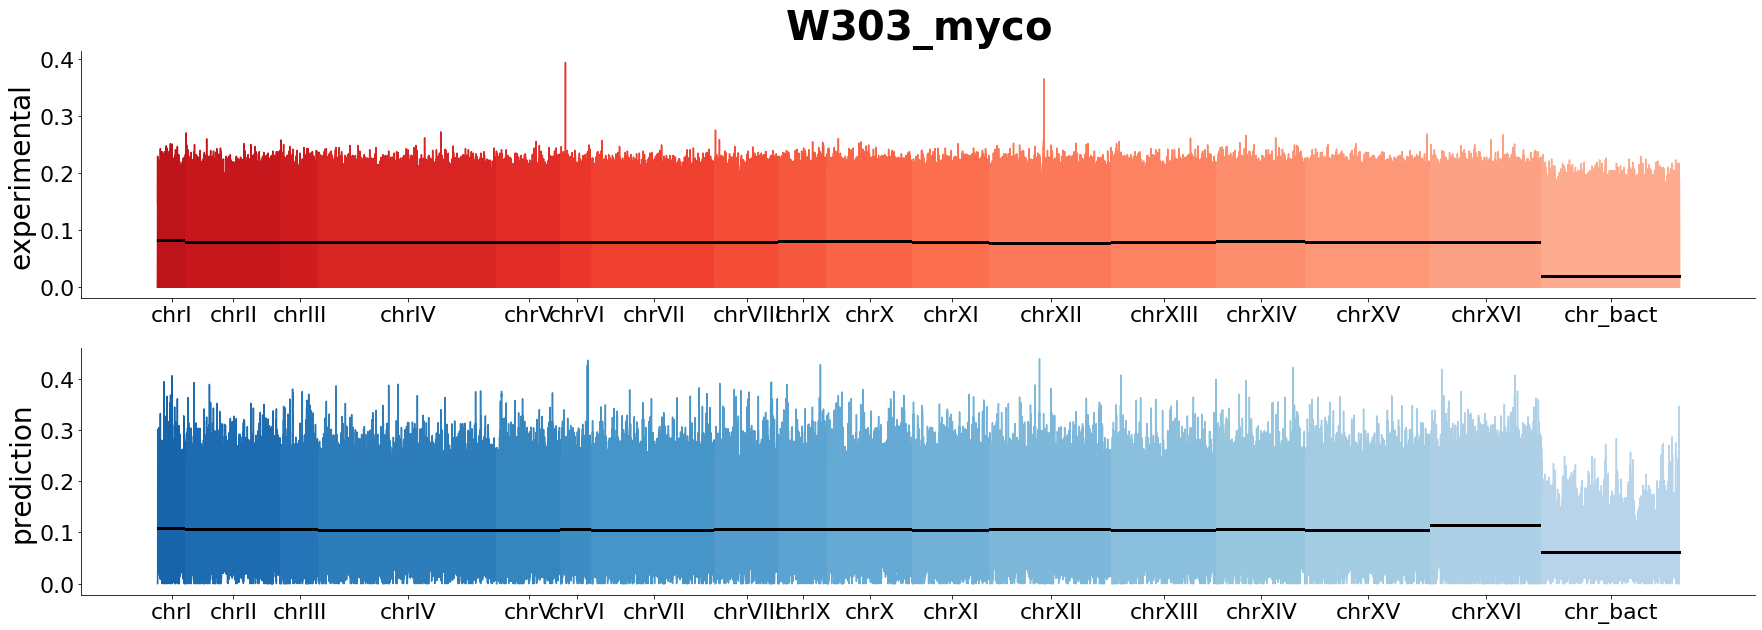

In [18]:
fig = plt.figure(figsize=(30, 10))

ax = fig.add_subplot(2, 1, 1)
start = 0
stop = 0
xticks = []

colors = plt.cm.Reds_r(np.linspace(0.2, 0.7, 17))

for i, chrom in enumerate(['chr01', 'chr02', 'chr03', 'chr04',
                          'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                          'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16',
                          'Mmm_Linear_740kb.fa']):

    prediction = myco_coverage_rep1[chrom]
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction, color=colors[i])
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start += len(prediction)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_title(r'$\bf{W303\_myco}$', fontsize=40)
ax.set_ylabel('experimental', fontsize=28)

ax = fig.add_subplot(2, 1, 2)
start = 0
stop = 0
xticks = []

colors = plt.cm.Blues_r(np.linspace(0.2, 0.7, 17))

for i, file in enumerate(yeast_myco_files + myco_file):
    prediction = np.log2(np.load(file) / threshold_myco + 1)
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction, color=colors[i])
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start +=len(prediction)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_ylabel('prediction', fontsize=28)

fig.savefig('./results/nucleosome_myco_whole_genome.png')

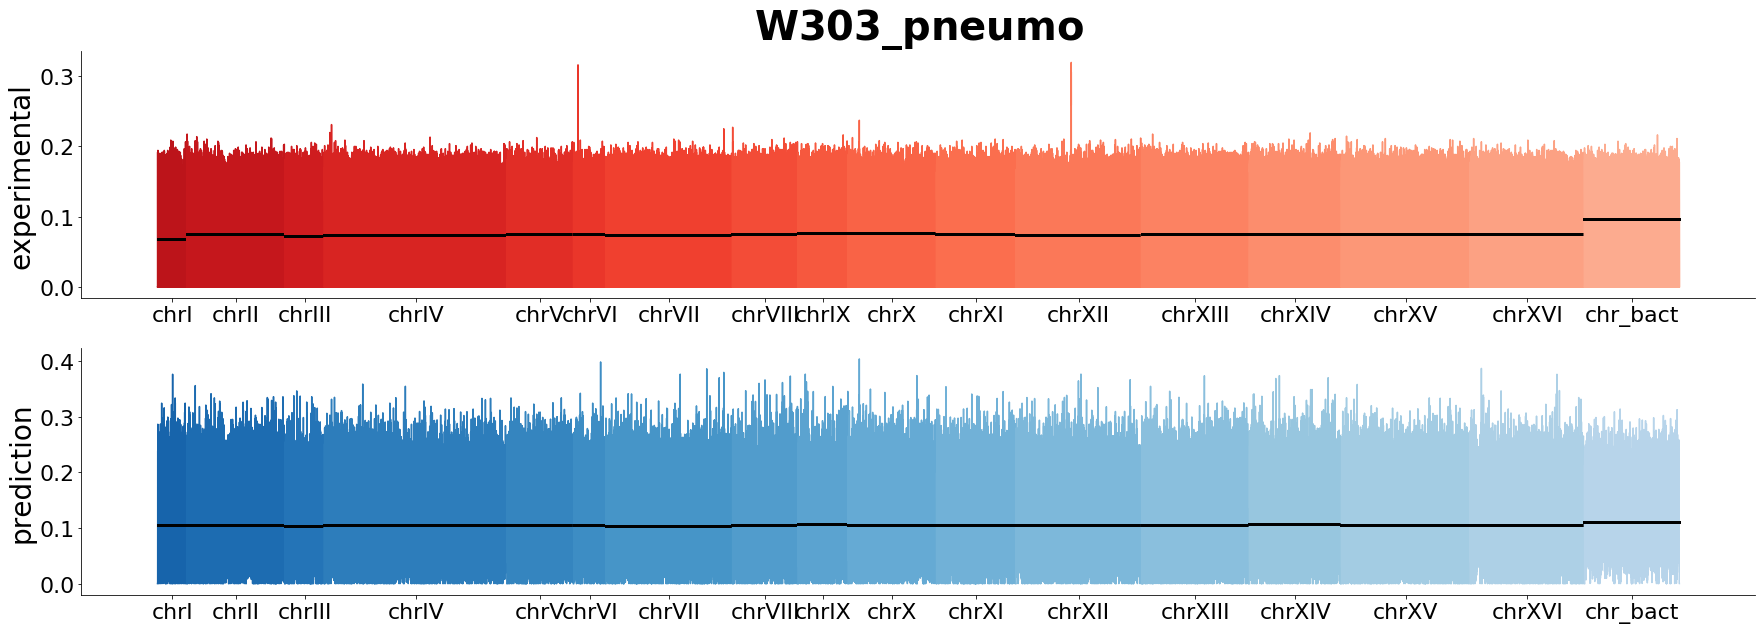

In [19]:
fig = plt.figure(figsize=(30, 10))

ax = fig.add_subplot(2, 1, 1)
start = 0
stop = 0
xticks = []

colors = plt.cm.Reds_r(np.linspace(0.2, 0.7, 17))

for i, chrom in enumerate(['chr01', 'chr02', 'chr03', 'chr04',
                          'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                          'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16',
                          'Pneu300']):

    prediction = pneu_coverage_rep1[chrom]
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction, color=colors[i])
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start += len(prediction)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_title(r'$\bf{W303\_pneumo}$', fontsize=40)
ax.set_ylabel('experimental', fontsize=28)

ax = fig.add_subplot(2, 1, 2)
start = 0
stop = 0
xticks = []

colors = plt.cm.Blues_r(np.linspace(0.2, 0.7, 17))

for i, file in enumerate(yeast_pneu_files + pneu_file):
    prediction = np.log2(np.load(file) / threshold_pneu + 1)
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction, color=colors[i])
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start +=len(prediction)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_ylabel('prediction', fontsize=28)

fig.savefig('./results/nucleosome_pneu_whole_genome.png')

# Comparaison avec les données expérimentales

In [7]:
roman_to_num = {'chrI' : 'chr01', 'chrII' : 'chr02', 'chrIII' : 'chr03', 'chrIV' : 'chr04', 'chrV' : 'chr05',
                'chrVI' : 'chr06', 'chrVII' : 'chr07', 'chrVIII' : 'chr08', 'chrIX' : 'chr09', 'chrX' : 'chr10', 'chrXI' : 'chr11',
                'chrXII' : 'chr12', 'chrXIII' : 'chr13', 'chrXIV' : 'chr14', 'chrXV' : 'chr15', 'chrXVI' : 'chr16', 'chrM' : 'chrM'} 

In [8]:
chrom_size = pd.read_csv('./data/W303.chrom.sizes', sep='\t', names=['chrom', 'sizes'])
chrom_size = {chrom : size for chrom, size in zip(chrom_size.chrom.values, chrom_size.sizes.values)}

In [9]:
chrom_size['Mmm_Linear_740kb.fa'] = 1222199
chrom_size['Pneu300'] = 817946

In [10]:
def read_bed(pathname):
    df = pd.read_csv(pathname, names=['chrom', 'start', 'stop', 'density'], sep='\t')
    coverages = dict()
    for chrom in df.chrom.unique():
        if chrom in chrom_size:
            local_df = df[df.chrom == chrom]
            coverage = np.zeros(chrom_size[chrom])

            for start, stop, density in zip(local_df.start.values, local_df.stop.values, local_df.density.values):
                coverage[start : stop] = np.log2(density + 1)
            coverages[chrom] = coverage
    
    all_coverage = np.concatenate([coverage for _, coverage in coverages.items()])
    threshold = np.sum(all_coverage) / 1e6
    
    for chrom, coverage in coverages.items():
        coverages[chrom] = coverage / threshold
    return coverages

### Myco

In [212]:
prediction = np.load('./results/bacterial/nucleosome_myco.npy')

In [11]:
myco_coverage_rep1 = read_bed('./data/for_Julien/myco/coverage_RPKM_myco265.bed')
myco_coverage_rep2 = read_bed('./data/for_Julien/myco/coverage_RPKM_myco266.bed')

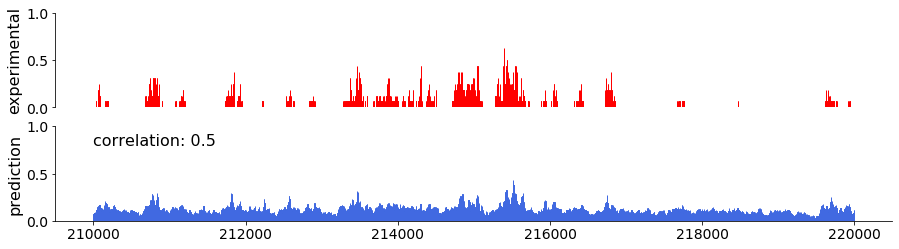

In [217]:
fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(4, 1, 2)
start = 210000
stop = 220000

ax.set_ylim([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.bar(x=np.arange(start, stop), height=prediction[start : stop], width=1, edgecolor='royalblue')
ax.set_facecolor('w')
ax.set_xticks(np.arange(start, stop + 1, 2000))
ax.set_xticklabels(np.arange(start, stop + 1, 2000), fontsize=14)
ax.set_yticks(np.arange(0, 1.1, 0.5))
ax.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax.set_ylabel('prediction', fontsize=16)
ax.text(x=start,
        y=0.8,
        s='correlation: {}'.format(np.round(np.corrcoef(myco_coverage_rep1['Mmm_Linear_740kb.fa'], prediction)[0, 1], 2)),
        fontsize=16)

ax1 = fig.add_subplot(4, 1, 1)
ax1.set_ylim([0, 1])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_xticks([])
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0, 1.1, 0.5))
ax1.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax1.bar(x=np.arange(start, stop), height=myco_coverage_rep1['Mmm_Linear_740kb.fa'][start : stop], width=1, edgecolor='r')
ax1.set_facecolor('w') 
ax1.set_ylabel('experimental', fontsize=16)

fig.savefig('./results/nucleosome_exp_vs_pred_myco_rep1.png')

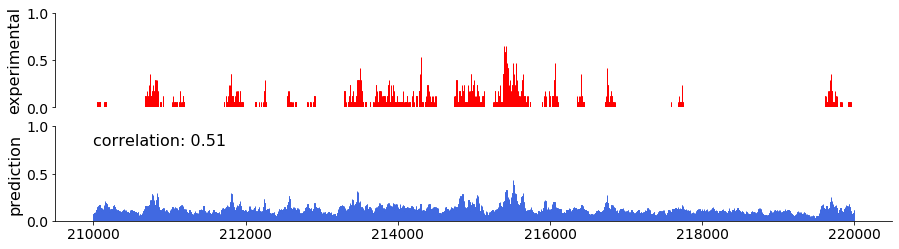

In [218]:
fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(4, 1, 2)

ax.set_ylim([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.bar(x=np.arange(start, stop), height=prediction[start : stop], width=1, edgecolor='royalblue')
ax.set_facecolor('w')
ax.set_xticks(np.arange(start, stop + 1, 2000))
ax.set_xticklabels(np.arange(start, stop + 1, 2000), fontsize=14)
ax.set_yticks(np.arange(0, 1.1, 0.5))
ax.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax.set_ylabel('prediction', fontsize=16)
ax.text(x=start,
        y=0.8,
        s='correlation: {}'.format(np.round(np.corrcoef(myco_coverage_rep2['Mmm_Linear_740kb.fa'][200000:], prediction[200000:])[0, 1], 2)),
        fontsize=16)

ax1 = fig.add_subplot(4, 1, 1)
ax1.set_ylim([0, 1])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_xticks([])
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0, 1.1, 0.5))
ax1.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax1.bar(x=np.arange(start, stop), height=myco_coverage_rep2['Mmm_Linear_740kb.fa'][start : stop], width=1, edgecolor='r')
ax1.set_facecolor('w') 
ax1.set_ylabel('experimental', fontsize=16)

fig.savefig('./results/nucleosome_exp_vs_pred_myco_rep2.png')

In [39]:
prediction = np.load('./results/yeast/nucleosome_myco_rep1_chr16.npy')

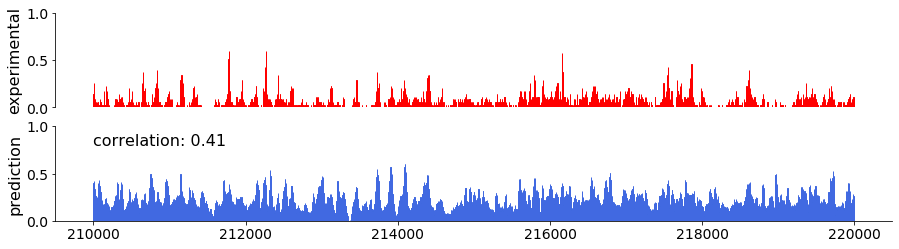

In [40]:
fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(4, 1, 2)
start = 210000
stop = 220000

ax.set_ylim([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.bar(x=np.arange(start, stop), height=prediction[start : stop], width=1, edgecolor='royalblue')
ax.set_facecolor('w')
ax.set_xticks(np.arange(start, stop + 1, 2000))
ax.set_xticklabels(np.arange(start, stop + 1, 2000), fontsize=14)
ax.set_yticks(np.arange(0, 1.1, 0.5))
ax.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax.set_ylabel('prediction', fontsize=16)
ax.text(x=start,
        y=0.8,
        s='correlation: {}'.format(np.round(np.corrcoef(myco_coverage_rep1['chr16'], prediction)[0, 1], 2)),
        fontsize=16)

ax1 = fig.add_subplot(4, 1, 1)
ax1.set_ylim([0, 1])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_xticks([])
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0, 1.1, 0.5))
ax1.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax1.bar(x=np.arange(start, stop), height=myco_coverage_rep1['chr16'][start : stop], width=1, edgecolor='r')
ax1.set_facecolor('w') 
ax1.set_ylabel('experimental', fontsize=16)

fig.savefig('./results/nucleosome_exp_vs_pred_yeast.png')

### Pneu300

In [219]:
prediction = np.load('./results/bacterial/nucleosome_pneu.npy')

In [13]:
pneu_coverage_rep1 = read_bed('./data/for_Julien/pneumo/coverage_RPKM_pneumo205.bed')
pneu_coverage_rep2 = read_bed('./data/for_Julien/pneumo/coverage_RPKM_pneumo206.bed')

In [127]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

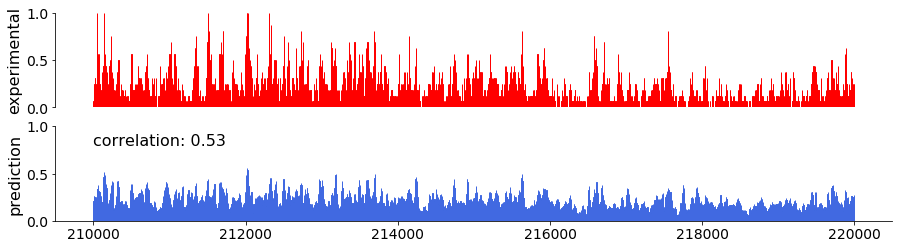

In [221]:
fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(4, 1, 2)
start = 210000
stop = 220000

ax.set_ylim([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.bar(x=np.arange(start, stop), height=prediction[start : stop], width=1, edgecolor='royalblue')
ax.set_facecolor('w')
ax.set_xticks(np.arange(start, stop + 1, 2000))
ax.set_xticklabels(np.arange(start, stop + 1, 2000), fontsize=14)
ax.set_yticks(np.arange(0, 1.1, 0.5))
ax.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax.set_ylabel('prediction', fontsize=16)
ax.text(x=start,
        y=0.8,
        s='correlation: {}'.format(np.round(np.corrcoef(pneu_coverage_rep1['Pneu300'], prediction)[0, 1], 2)),
        fontsize=16)

ax1 = fig.add_subplot(4, 1, 1)
ax1.set_ylim([0, 1])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_xticks([])
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0, 1.1, 0.5))
ax1.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax1.bar(x=np.arange(start, stop), height=pneu_coverage_rep1['Pneu300'][start : stop], width=1, edgecolor='r')
ax1.set_facecolor('w') 
ax1.set_ylabel('experimental', fontsize=16)

fig.savefig('./results/nucleosome_exp_vs_pred_pneu_rep1.png')

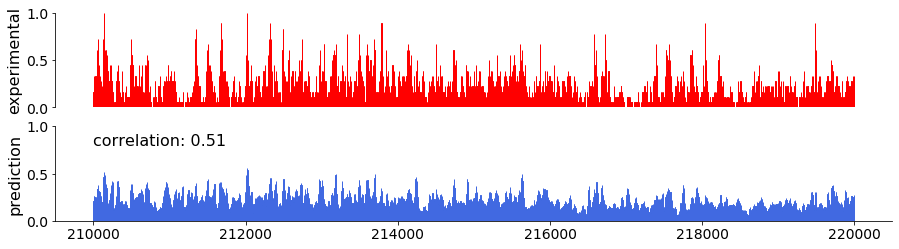

In [222]:
fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(4, 1, 2)
start = 210000
stop = 220000

ax.set_ylim([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.bar(x=np.arange(start, stop), height=prediction[start : stop], width=1, edgecolor='royalblue')
ax.set_facecolor('w')
ax.set_xticks(np.arange(start, stop + 1, 2000))
ax.set_xticklabels(np.arange(start, stop + 1, 2000), fontsize=14)
ax.set_yticks(np.arange(0, 1.1, 0.5))
ax.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax.set_ylabel('prediction', fontsize=16)
ax.text(x=start,
        y=0.8,
        s='correlation: {}'.format(np.round(np.corrcoef(pneu_coverage_rep2['Pneu300'], prediction)[0, 1], 2)),
        fontsize=16)

ax1 = fig.add_subplot(4, 1, 1)
ax1.set_ylim([0, 1])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_xticks([])
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0, 1.1, 0.5))
ax1.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax1.bar(x=np.arange(start, stop), height=pneu_coverage_rep2['Pneu300'][start : stop], width=1, edgecolor='r')
ax1.set_facecolor('w') 
ax1.set_ylabel('experimental', fontsize=16)

fig.savefig('./results/nucleosome_exp_vs_pred_pneu_rep1.png')

In [43]:
prediction = np.load('./results/yeast/nucleosome_pneu_rep1_chr16.npy')

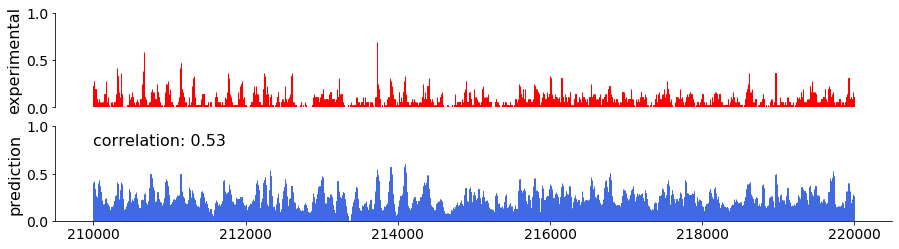

In [44]:
fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(4, 1, 2)
start = 210000
stop = 220000

ax.set_ylim([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.bar(x=np.arange(start, stop), height=prediction[start : stop], width=1, edgecolor='royalblue')
ax.set_facecolor('w')
ax.set_xticks(np.arange(start, stop + 1, 2000))
ax.set_xticklabels(np.arange(start, stop + 1, 2000), fontsize=14)
ax.set_yticks(np.arange(0, 1.1, 0.5))
ax.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax.set_ylabel('prediction', fontsize=16)
ax.text(x=start,
        y=0.8,
        s='correlation: {}'.format(np.round(np.corrcoef(pneu_coverage_rep1['chr16'], prediction)[0, 1], 2)),
        fontsize=16)

ax1 = fig.add_subplot(4, 1, 1)
ax1.set_ylim([0, 1])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_xticks([])
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0, 1.1, 0.5))
ax1.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax1.bar(x=np.arange(start, stop), height=pneu_coverage_rep1['chr16'][start : stop], width=1, edgecolor='r')
ax1.set_facecolor('w') 
ax1.set_ylabel('experimental', fontsize=16)

fig.savefig('./results/nucleosome_exp_vs_pred_pneu_yeast.png')

### Evaluation of the mean prediction with the CG-content

In [62]:
predict_and_save('../Projet_nucleosomes/Programme/seq_chr_sacCer3/covid19/chr1.hdf5',
              './results/covid19/nucleosome_coverage_3.npy')

In [14]:
def random_sequence(gc=0.4, batch_size=10000):
    return np.concatenate([one_hot_encoder(np.random.choice([1, 2, 3, 4],
                                                     WINDOW,
                                                     p=[0.5 - gc / 2., 0.5 - gc / 2., gc / 2., gc / 2.]))[None, ...]\
                                   for _ in range(batch_size)], axis=0)[:, :, None, :]

def get_gc_content(filename):
    seq_chr = np.array(h5py.File(filename)['data'])[:, 0]
    
    gc_content = np.unique(seq_chr, return_counts=True)[1]
    
    if len(gc_content) == 5:
        return np.sum(gc_content[3:]) / len(seq_chr)
    else:
        return np.sum(gc_content[2:]) / len(seq_chr)

In [15]:
def reverse_complement_(sequence):
    seq = np.copy(sequence)
    seq[seq == 1] = 5
    seq[seq == 2] = 1
    seq[seq == 5] = 2
    seq[seq == 3] = 5
    seq[seq == 4] = 3
    seq[seq == 5] = 4
    return seq[::-1]

def reverse_complement(sequence, length):
    encoded_seq = np.where(sequence == 1)[3] + 1
    return np.concatenate([one_hot_encoder(reverse_complement_(encoded_seq[i * length : (i + 1) * length]))[None, :, None, :] for i in range(len(encoded_seq) // length)])

In [46]:
diff_rc_direct = []

for gc in np.arange(0, 1.01, 0.01):
    x_direct = random_sequence(gc=gc, batch_size=10000)
    x_rc = reverse_complement(x_direct, WINDOW)

    pred_direct = model.predict(x_direct)
    rc_pred = model.predict(x_rc)
    diff = np.abs(pred_direct - rc_pred)

    diff_rc_direct.append(np.sum(diff[pred_direct > 0.0] / pred_direct[pred_direct > 0.0] > 0.3) / 10000)

Text(0, 0.5, 'pourcentage $\\Delta$ significatif')

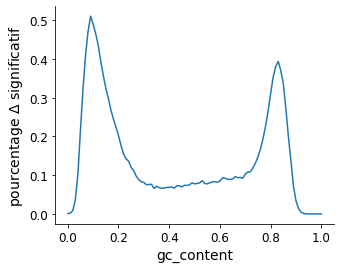

In [49]:
fig = plt.figure(figsize=(5, 4))

ax = fig.add_subplot(1, 1, 1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.plot(np.arange(0, 1.01, 0.01), diff_rc_direct)
ax.set_xlabel('gc_content', fontsize=14)
ax.set_ylabel(r'pourcentage $\Delta$ significatif', fontsize=14)

In [16]:
models = [keras.models.load_model('./models/weights_myco_rep1.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor}),
         keras.models.load_model('./models/weights_nucleosome_myco_rep2.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor}),
         keras.models.load_model('./models/weights_nucleosome_myco_rep3.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
means = [np.mean(np.concatenate([model.predict(random_sequence(gc=gc)) for model in models])) for gc in np.arange(0, 1.05, 0.05)]
stds = [np.std(np.concatenate([model.predict(random_sequence(gc=gc)) for model in models])) for gc in np.arange(0, 1.05, 0.05)]

In [18]:
gc_content_yeast = np.mean([get_gc_content('../Projet_nucleosomes/Programme/seq_chr_sacCer3/W303/chr' + str(i) + '.hdf5') for i in range(1,17)])
mean_coverage_yeast = np.mean(np.concatenate([np.load('./results/yeast/nucleosome_chr' + str(i) + '.npy') for i in range(1,17)] + \
                                             [np.load('./results/yeast/nucleosome_myco_rep2_chr' + str(i) + '.npy') for i in range(1,17)] + \
                                             [np.load('./results/yeast/nucleosome_myco_rep3_chr' + str(i) + '.npy') for i in range(1,17)]))
std_coverage_yeast = np.std(np.concatenate([np.load('./results/yeast/nucleosome_chr' + str(i) + '.npy') for i in range(1,17)] + \
                                             [np.load('./results/yeast/nucleosome_myco_rep2_chr' + str(i) + '.npy') for i in range(1,17)] + \
                                             [np.load('./results/yeast/nucleosome_myco_rep3_chr' + str(i) + '.npy') for i in range(1,17)]))

In [19]:
df_artificial = pd.DataFrame({'species' : np.repeat('artificial', len(means)),
                   'type' : np.repeat('predicted', len(means)),
                   'mean' : means,
                   'std' : stds,
                   'gc' : np.arange(0, 1.05, 0.05)})

df_mmm_pred = pd.DataFrame({'species' : np.repeat('Mmm_linear', 1),
                       'type' : np.repeat('predicted', 1),
                       'mean' : [np.mean(np.concatenate([np.load('./results/bacterial/nucleosome_myco.npy'),
                                     np.load('./results/bacterial/nucleosome_myco_2.npy'),
                                     np.load('./results/bacterial/nucleosome_myco_3.npy')]))],
                       'std' : [np.std(np.concatenate([np.load('./results/bacterial/nucleosome_myco.npy'),
                                     np.load('./results/bacterial/nucleosome_myco_2.npy'),
                                     np.load('./results/bacterial/nucleosome_myco_3.npy')]))],
                       'gc' : [get_gc_content('./data/bacterie/Mmm_Linear_740kb.hdf5')]})

df_pneu_pred = pd.DataFrame({'species' : np.repeat('Pneu300', 1),
                       'type' : np.repeat('predicted', 1),
                       'mean' : [np.mean(np.concatenate([np.load('./results/bacterial/nucleosome_pneu.npy'),
                                     np.load('./results/bacterial/nucleosome_pneu_2.npy'),
                                     np.load('./results/bacterial/nucleosome_pneu_3.npy')]))],
                       'std' : [np.std(np.concatenate([np.load('./results/bacterial/nucleosome_pneu.npy'),
                                     np.load('./results/bacterial/nucleosome_pneu_2.npy'),
                                     np.load('./results/bacterial/nucleosome_pneu_3.npy')]))],
                       'gc' : [get_gc_content('./data/bacterie/Pneu300.hdf5')]})

df_cerevisiae_pred = pd.DataFrame({'species' : np.repeat('scerevisiae', 1),
                       'type' : np.repeat('predicted', 1),
                       'mean' : [mean_coverage_yeast],
                       'std' : [std_coverage_yeast],
                       'gc' : [gc_content_yeast]})

df_covid_pred = pd.DataFrame({'species' : np.repeat('covid', 1),
                       'type' : np.repeat('predicted', 1),
                       'mean' : [np.mean(np.concatenate([np.load('./results/covid19/nucleosome_coverage.npy'),
                                     np.load('./results/covid19/nucleosome_coverage_2.npy'),
                                     np.load('./results/covid19/nucleosome_coverage_3.npy')]))],
                       'std' : [np.std(np.concatenate([np.load('./results/covid19/nucleosome_coverage.npy'),
                                     np.load('./results/covid19/nucleosome_coverage_2.npy'),
                                     np.load('./results/covid19/nucleosome_coverage_3.npy')]))],
                       'gc' : [get_gc_content('../Projet_nucleosomes/Programme/seq_chr_sacCer3/covid19/chr1.hdf5')]})

df_mmm_true = pd.DataFrame({'species' : np.repeat('Mmm_linear', 1),
                       'type' : np.repeat('true', 1),
                       'mean' : [np.mean(myco_coverage_rep1['Mmm_Linear_740kb.fa'])],
                       'std' : [np.std(myco_coverage_rep1['Mmm_Linear_740kb.fa'])],
                       'gc' : [get_gc_content('./data/bacterie/Mmm_Linear_740kb.hdf5')]})

df_pneu_true = pd.DataFrame({'species' : np.repeat('Pneu300', 1),
                       'type' : np.repeat('true', 1),
                       'mean' : [np.mean(pneu_coverage_rep1['Pneu300'])],
                       'std' : [np.std(pneu_coverage_rep1['Pneu300'])],
                       'gc' : [get_gc_content('./data/bacterie/Pneu300.hdf5')]})

df_cerevisiae_true = pd.DataFrame({'species' : np.repeat('scerevisiae', 1),
                       'type' : np.repeat('true', 1),
                       'mean' : [np.mean(np.concatenate([myco_coverage_rep1[chrom] for chrom in ['chr01', 'chr02', 'chr03', 'chr04',
                                                                             'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                                                                             'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16']]))],
                       'std' : [np.std(np.concatenate([myco_coverage_rep1[chrom] for chrom in ['chr01', 'chr02', 'chr03', 'chr04',
                                                                             'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                                                                             'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16']]))],
                       'gc' : [gc_content_yeast]})

In [20]:
df = df_artificial.append(df_mmm_pred).append(df_pneu_pred).append(df_cerevisiae_pred).append(df_covid_pred).append(df_mmm_true).append(df_pneu_true).append(df_cerevisiae_true)
df.to_csv('datapoints/nucleosome_datapoints.csv', index=False)

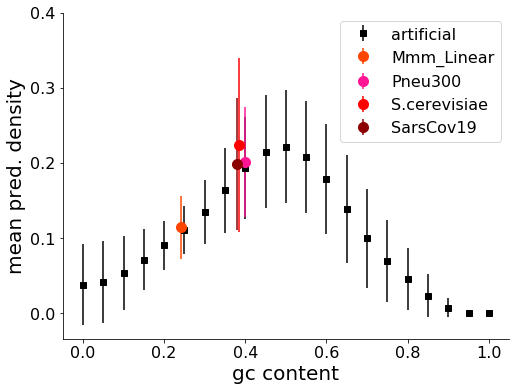

In [70]:
fig = plt.figure(figsize=(8, 6))

markersize = 10

ax = fig.add_subplot(1, 1, 1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.errorbar(np.arange(0, 1.05, 0.05),
            means,
            linestyle='',
            marker='s',
            yerr=stds,
            color='k',
            label='artificial')
ax.errorbar([get_gc_content('./data/bacterie/Mmm_Linear_740kb.hdf5')],
            [np.mean(np.concatenate([np.load('./results/bacterial/nucleosome_myco.npy'),
                                     np.load('./results/bacterial/nucleosome_myco_2.npy'),
                                     np.load('./results/bacterial/nucleosome_myco_3.npy')]))],
             marker='o',
             markersize=markersize,
             linestyle='',
             yerr=[np.std(np.concatenate([np.load('./results/bacterial/nucleosome_myco.npy'),
                                     np.load('./results/bacterial/nucleosome_myco_2.npy'),
                                     np.load('./results/bacterial/nucleosome_myco_3.npy')]))],
             color='orangered',
             label='Mmm_Linear')

ax.errorbar([get_gc_content('./data/bacterie/Pneu300.hdf5')],
            [np.mean(np.concatenate([np.load('./results/bacterial/nucleosome_pneu.npy'),
                                     np.load('./results/bacterial/nucleosome_pneu_2.npy'),
                                     np.load('./results/bacterial/nucleosome_pneu_3.npy')]))],
             marker='o',
             markersize=markersize,
             linestyle='',
             yerr=[np.std(np.concatenate([np.load('./results/bacterial/nucleosome_pneu.npy'),
                                     np.load('./results/bacterial/nucleosome_pneu_2.npy'),
                                     np.load('./results/bacterial/nucleosome_pneu_3.npy')]))],
             color='deeppink',
             label='Pneu300')

ax.errorbar([gc_content_yeast],
            [mean_coverage_yeast],
             marker='o',
             markersize=markersize,
             linestyle='',
             yerr=[std_coverage_yeast],
             color='red',
             label='S.cerevisiae')

ax.errorbar([get_gc_content('../Projet_nucleosomes/Programme/seq_chr_sacCer3/covid19/chr1.hdf5')],
            [np.mean(np.concatenate([np.load('./results/covid19/nucleosome_coverage.npy'),
                                     np.load('./results/covid19/nucleosome_coverage_2.npy'),
                                     np.load('./results/covid19/nucleosome_coverage_3.npy')]))],
             marker='o',
             markersize=markersize,
             linestyle='',
             yerr=[np.std(np.concatenate([np.load('./results/covid19/nucleosome_coverage.npy'),
                                     np.load('./results/covid19/nucleosome_coverage_2.npy'),
                                     np.load('./results/covid19/nucleosome_coverage_3.npy')]))],
             color='darkred',
             label='SarsCov19')
ax.legend(fontsize=16)
ax.set_xticks(np.arange(0, 1.05, 0.2))
ax.set_xticklabels(np.round(np.arange(0, 1.05, 0.2), 2), fontsize=16)
ax.set_yticks(np.arange(0, 0.45, 0.1))
ax.set_yticklabels(np.round(np.arange(0, 0.45, 0.1), 2), fontsize=16)
ax.set_xlabel('gc content', fontsize=20)
ax.set_ylabel('mean pred. density', fontsize=20)

fig.savefig('./results/gc_content_evolution_nucleosome_2.png')

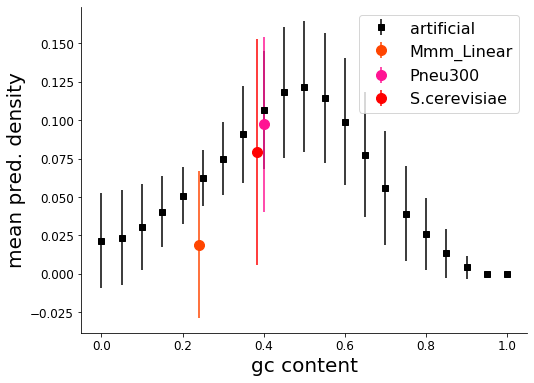

In [79]:
fig = plt.figure(figsize=(8, 6))

markersize = 10

ax = fig.add_subplot(1, 1, 1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.errorbar(np.arange(0, 1.05, 0.05),
            np.log2(means / threshold_myco + 1),
            linestyle='',
            marker='s',
            yerr=np.log2(stds / threshold_myco + 1),
            color='k',
            label='artificial')
ax.errorbar([get_gc_content('./data/bacterie/Mmm_Linear_740kb.hdf5')],
            [np.mean(myco_coverage_rep1['Mmm_Linear_740kb.fa'])],
             marker='o',
             markersize=markersize,
             linestyle='',
             yerr=[np.std(myco_coverage_rep1['Mmm_Linear_740kb.fa'])],
             color='orangered',
             label='Mmm_Linear')

ax.errorbar([get_gc_content('./data/bacterie/Pneu300.hdf5')],
            [np.mean(pneu_coverage_rep1['Pneu300'])],
             marker='o',
             markersize=markersize,
             linestyle='',
             yerr=[np.std(pneu_coverage_rep1['Pneu300'])],
             color='deeppink',
             label='Pneu300')

ax.errorbar([gc_content_yeast],
            [np.mean(np.concatenate([myco_coverage_rep1[chrom] for chrom in ['chr01', 'chr02', 'chr03', 'chr04',
                                                                             'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                                                                             'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16']]))],
             marker='o',
             markersize=markersize,
             linestyle='',
             yerr=[np.std(np.concatenate([myco_coverage_rep1[chrom] for chrom in ['chr01', 'chr02', 'chr03', 'chr04',
                                                                                  'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                                                                                  'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16']]))],
             color='red',
             label='S.cerevisiae')


ax.legend(fontsize=16)
ax.set_xlabel('gc content', fontsize=20)
ax.set_ylabel('mean pred. density', fontsize=20)
fig.savefig('./results/gc_content_evolution_nucleosome_experimental.png')

In [83]:
### Calculating the GC content

In [116]:
def get_gc_content_(seq_chr):    
    gc_content = np.unique(seq_chr, return_counts=True)[1]
    if len(gc_content) == 5:
        return np.sum(gc_content[3:]) / len(seq_chr)
    else:
        return np.sum(gc_content[2:]) / len(seq_chr)

def get_gc_yeast(window=100):
    seq_chr = np.concatenate([np.array(h5py.File('../Projet_nucleosomes/Programme/seq_chr_sacCer3/W303/chr' + str(i) + '.hdf5')['data'])[:, 0] for i in range(1, 17)])
    cut_seq = rolling_window(seq_chr, window=window, asteps=window)
    return np.array([get_gc_content_(seq) for seq in cut_seq])

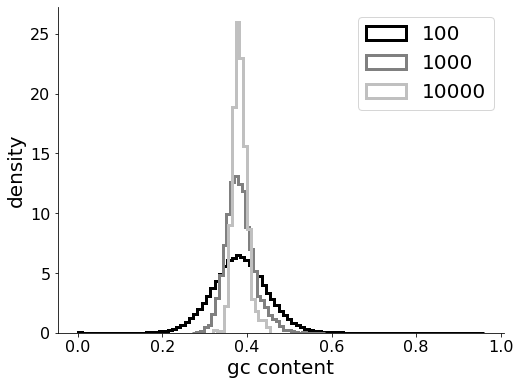

In [138]:
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.hist(get_gc_yeast(100), bins=95, density=True, histtype='step', linewidth=3, color='k', label='100')
ax.hist(get_gc_yeast(1000), bins=35, density=True, histtype='step', linewidth=3, color='grey', label='1000')
ax.hist(get_gc_yeast(10000), bins=15, density=True, histtype='step', linewidth=3, color='silver', label='10000')

ax.set_xlabel('gc content', fontsize=20)
ax.set_ylabel('density', fontsize=20)
ax.legend(fontsize=20)

fig.savefig('./results/gc_content_on_yeast.png')